##**HOMEWORK 09**
###**RNNs**
### IANNWTF
###Group 02

In [74]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from IPython import display
import time 
import random
# print(tf.__version__)

### **Generating the Data**

In [81]:
import random

# Batching only works if the inputs have the same size, so we can't really use it
BATCH=1 

def sequence(number,seed=1):
  ''' This function creates both a sequence of random digits and the two random quired digits. 
  '''
  i=0
  random.seed(seed)
  while i<number:
    # 1. Create a random sequence of random length. At least half of them should be small, so that the LSTM has a starting stone 
    seqLen=random.randint(1,5) if random.randint(1,2)==1 else random.randint(1,20) 
    seq=[]
    for j in range(seqLen):
      seq.append(random.randint(0,9))

    # 2. Count the occurrences of two random digits. If both digits have the same frecuency (or are not in the sequence) repeat with new digits
    # Generate the two queried digits (context)
    n1=0
    n2=0
    while n1+n2 == 0:
      # Context digit 1
      c1=random.randint(0,9)
      # Context digit 2
      c2=random.randint(0,9)

      # Count number of times context digits occur in the sequence
      n1=seq.count(c1)
      n2=seq.count(c2)
    # So far of the form (now summarize with a list of the form [(digit1,digit2,sequenceDigit_j)]
    final=[]
    for j in range(seqLen):
      final.append((c1,c2,seq[j]))
    # return the sequence-list and 1 if the first digit is more frecuent else 0
    yield (final,(1. if n1>n2 else 0.)) #(1. if n1>n2 else 0.)) 
    i+=1

def getDataset(size,seed):
  ''' This function generates the dataset our model is going to work with
  '''
  data_set = tf.data.Dataset.from_generator(sequence,args= [size,seed],output_types = (tf.int32,tf.float32))

  # Perform one_hot encoding 
  final_set=data_set.map(lambda x,y:(tf.one_hot(x,10),y))
  final_set = final_set.shuffle(buffer_size=128)
  final_set = final_set.batch(BATCH)
  final_set = final_set.prefetch(tf.data.experimental.AUTOTUNE)
  return final_set


# Generate the traning dataset
train_dataset = getDataset(10000,1)
# Let's look at one of the training sets
for i in train_dataset:
  print(i)
  break
# generate the testing dataset
test_dataset = getDataset(1000,2)

(<tf.Tensor: shape=(1, 3, 3, 10), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)


##**The RNNs Network**
Our LSTM-cell consists basically of four Dense Layers with 30 units each and an input of size 60 (30 for the real input and 30 for the hidden states).

In [82]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

# The long short term memory Cell
class LSTM_Cell(Layer):
  def __init__(self):
    super(LSTM_Cell, self).__init__()
    self.forgetg=tf.keras.layers.Dense(units=30,activation=tf.keras.activations.sigmoid,bias_initializer='ones',input_shape=(1,60)) #note the different bias_initializer
    self.inputg=tf.keras.layers.Dense(units=30,activation=tf.keras.activations.sigmoid,input_shape=(1,60))
    self.outputg=tf.keras.layers.Dense(units=30,activation=tf.keras.activations.sigmoid,input_shape=(1,60))
    self.cell=tf.keras.layers.Dense(units=30,activation=tf.keras.activations.tanh,input_shape=(1,60))

  #implement the math as in the courseware
  def call(self,input,states):
    (hidden_state,cell_state)=states
    input_concat=tf.concat([hidden_state,input],axis=1)
    forget_gate=self.forgetg(input_concat)
    input_gate=self.inputg(input_concat)
    output_gate=self.outputg(input_concat)
    cell_state_candidates=self.cell(input_concat)
    new_cell_state=tf.keras.layers.Add()([tf.keras.layers.multiply([forget_gate,cell_state]),tf.keras.layers.multiply([input_gate,cell_state_candidates])])
    new_hidden_state=tf.keras.layers.multiply([output_gate,tf.keras.activations.tanh(new_cell_state)])
    output=new_hidden_state
    return (output,new_hidden_state,new_cell_state)


Next, now that we have the lstm_cell, we construct the normal LSTM which is a small read-in and read-out layers, an output of 1 (binary classification).

In [83]:
# The long short term memory Model
class LSTM(Model):

  def __init__(self):
    super(LSTM, self).__init__()
    self.reshape=tf.keras.layers.Reshape((30,))
    self.readin=tf.keras.layers.Dense(units=30,activation=tf.keras.activations.relu,input_shape=(30,))
    self.lstm=LSTM_Cell()
    self.readout=tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)


  @tf.function
  def call(self,input):
    # Define our starting hidden/cell states
    h=tf.zeros((len(input),30))
    c=tf.zeros((len(input),30))
    outputs=[]
    for i in range(len(input[0])):
      # Takes the input for this timestep for all the different batches
      timed_input=input[:,i] 
      timed_input=self.reshape(timed_input)
      timed_input=self.readin(timed_input)
      (x,h,c)=self.lstm.call(timed_input,(h,c))
      # what was the output for this time step
      outputs.append(self.readout(x)) 

    # But in reality we only care for the last one
    return outputs[-1] 
    
      

Below, we define the training and testing step as it was specified in the course material and documentation

In [84]:
# Define the training step
def train_step(model, input, target, loss_function, optimizer):

  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

# Define the testing step
def test(model, test_data, loss_function):
  
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)

    sample_test_loss = loss_function(target, prediction)
    prediction=tf.math.round(prediction)
    target=tf.math.round(target)
    sample_test_accuracy =  tf.math.equal(target,prediction)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [85]:
# Funtcion to plot losses and accuracies
def plot_accuracy(train_losses,test_losses,test_accuracies):
  # Plot training and test loss.
  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2),("training","test"))
  plt.show()

  # Plot test accuracy.
  plt.figure()
  line1, = plt.plot(test_accuracies)
  plt.title(f'Total Acuraccy: {np.max(test_accuracies)}')
  plt.xlabel("Training steps")
  plt.ylabel("Accuracy")
  plt.show()

Finally, we get to run the model and visualize the losses and accuracies. 

Epoch: _30


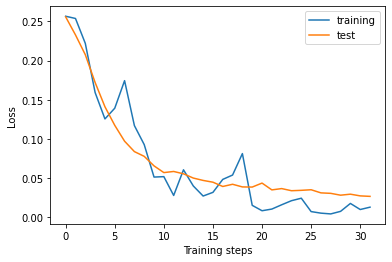

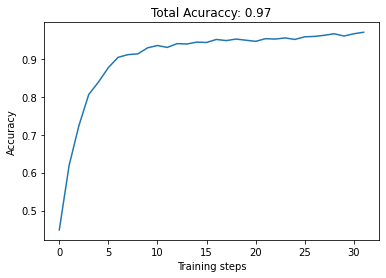


This training took: 50 minutes and 9.93923544883728 seconds.


In [86]:
# As specified in the course material and documentation
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 30
learning_rate = 0.0001
running_average_factor = 0.95

# Set the time
start = time.time()

# Initialize the model.
model = LSTM()
# Initialize the loss: mean squared error Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.MSE
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(0, num_epochs + 1):

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    # Training
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    # Testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    # Clear after new epoch
    display.clear_output(wait=True)
    print(f'Epoch: _{epoch}')
    plot_accuracy(train_losses, test_losses, test_accuracies)

# Keep track of the time 
end = time.time()
duration = end - start

print(f'\nThis training took: {int (duration / 60)} minutes and {(duration % 60)} seconds.')